In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models import Six

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

/home/hoangphuc/miniconda3/envs/gene/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class2idx = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2class = {v: k for k, v in class2idx.items()}

testloader = []

with open('data/val_six.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_six_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_six.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_six_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test = np.concatenate([x_test0, x_test1])
y_test = np.concatenate([y_test0, y_test1])

Six(
  (fc1): Linear(in_features=8630, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Accuracy: 0.8070175438596491
F1 score five: 0.7938788335847159
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       0.73      0.89      0.80         9
           2       0.73      0.89      0.80         9
           3       1.00      0.50      0.67        10
           4       0.92      0.92      0.92        13
           5

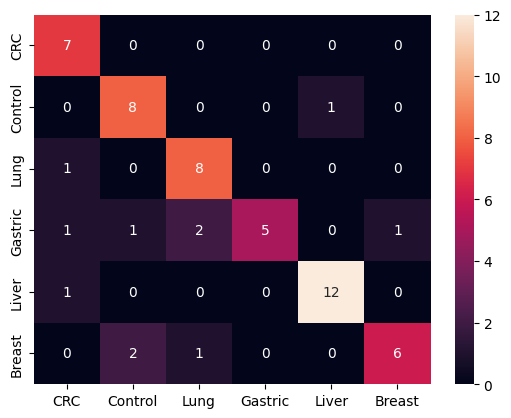

In [3]:
checkpoint_path="checkpoints/ckp_six.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Six()
print(model)
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_dict['net'])
model.to(device)

y_pred_list = []

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())

testloader = DataLoader(dataset=test_dataset, batch_size=1)

with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(f'Accuracy: {accuracy_score(y_test, y_pred_list)}')

f1 = f1_score(y_test, y_pred_list, average='macro')
print(f'F1 score five: {f1}')
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, y_pred_list))

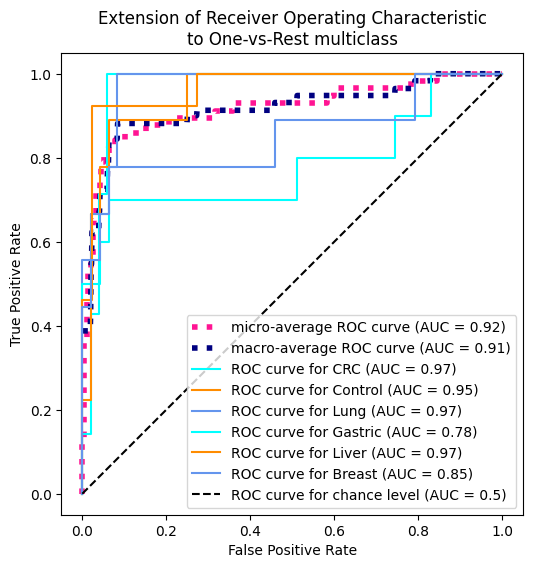

In [4]:
y_score = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        tmp = y_test_pred.cpu().numpy()[0]
        lst = [-l/sum(tmp) for l in tmp]
        y_score.append(lst)
y_score = np.array(y_score)

n_classes = 6
target_names = np.array(["CRC","Control","Lung","Gastric","Liver","Breast"])

label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

# Machine Learning

In [5]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

In [6]:
# load the model from disk
filename = 'checkpoints/ml_svm_six.sav'
svm_ = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_rf_six.sav'
rf = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_knn_six.sav'
knn = pickle.load(open(filename, 'rb'))

class2idx = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2class = {v: k for k, v in class2idx.items()}

testloader = []

with open('data/val_six.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_six_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_six.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_six_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test = np.concatenate([x_test0, x_test1])
y_test = np.concatenate([y_test0, y_test1])



Accuracy SVM: 0.6842105263157895
F1 score SVM: 0.6589064573197699
              precision    recall  f1-score   support

           0       0.46      0.86      0.60         7
           1       0.70      0.78      0.74         9
           2       0.60      0.33      0.43         9
           3       0.83      0.50      0.62        10
           4       0.80      0.92      0.86        13
           5       0.75      0.67      0.71         9

    accuracy                           0.68        57
   macro avg       0.69      0.68      0.66        57
weighted avg       0.71      0.68      0.67        57



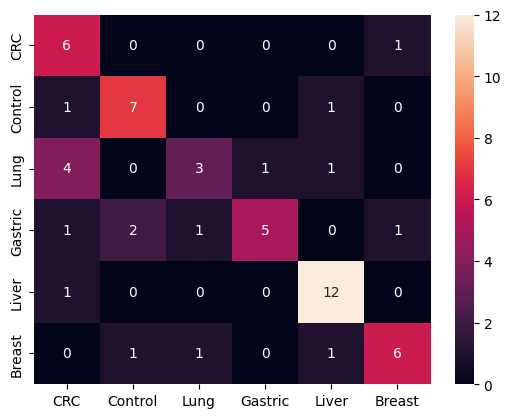

In [7]:
print(f'Accuracy SVM: {accuracy_score(y_test, svm_.predict(x_test))}')

f1_svm = f1_score(y_test, svm_.predict(x_test), average='macro')
print(f'F1 score SVM: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, svm_.predict(x_test))).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, svm_.predict(x_test)))

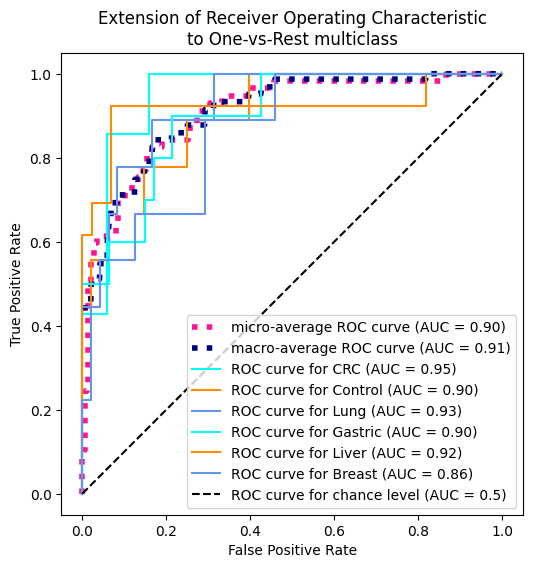

In [8]:
n_classes = 6
target_names = np.array(["CRC", "Control","Lung","Gastric","Liver","Breast"])
y_score = svm_.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy random forest: 0.5263157894736842
F1 score random forest: 0.527936876504988
              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.18      0.22      0.20         9
           2       0.71      0.56      0.63         9
           3       0.71      0.50      0.59        10
           4       0.73      0.62      0.67        13
           5       0.40      0.44      0.42         9

    accuracy                           0.53        57
   macro avg       0.55      0.53      0.53        57
weighted avg       0.56      0.53      0.53        57



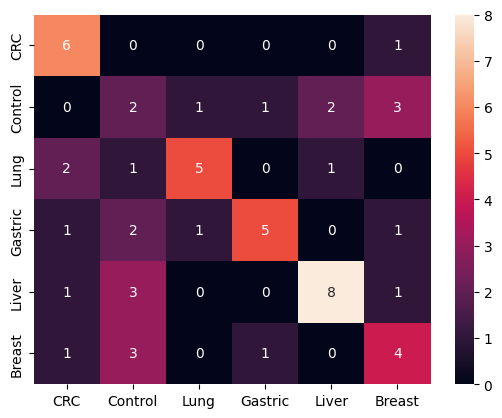

In [9]:
print(f'Accuracy random forest: {accuracy_score(y_test, rf.predict(x_test))}')

f1_rf = f1_score(y_test, rf.predict(x_test), average='macro')
print(f'F1 score random forest: {f1_rf}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, rf.predict(x_test))).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, rf.predict(x_test)))

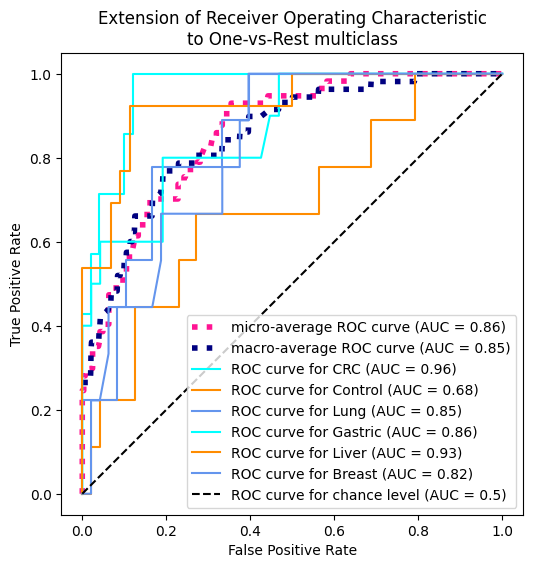

In [10]:
n_classes = 6
target_names = np.array(["CRC", "Control","Lung","Gastric","Liver","Breast"])
y_score = rf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy KNN: 0.6666666666666666
F1 score KNN: 0.6667998994469583
              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.44      0.78      0.56         9
           2       0.83      0.56      0.67         9
           3       1.00      0.60      0.75        10
           4       0.77      0.77      0.77        13
           5       0.83      0.56      0.67         9

    accuracy                           0.67        57
   macro avg       0.73      0.66      0.67        57
weighted avg       0.74      0.67      0.68        57



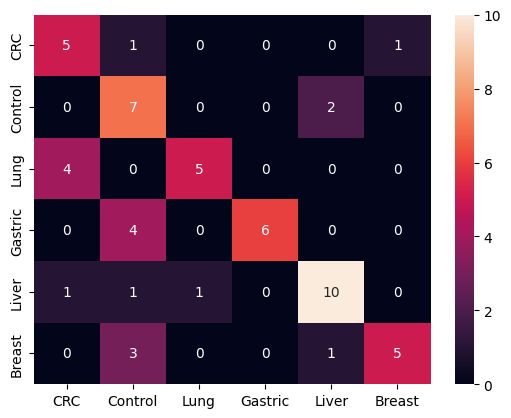

In [13]:
print(f'Accuracy KNN: {accuracy_score(y_test, knn.predict(x_test))}')

f1_knn = f1_score(y_test, knn.predict(x_test), average='macro')
print(f'F1 score KNN: {f1_knn}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, knn.predict(x_test))).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, knn.predict(x_test)))

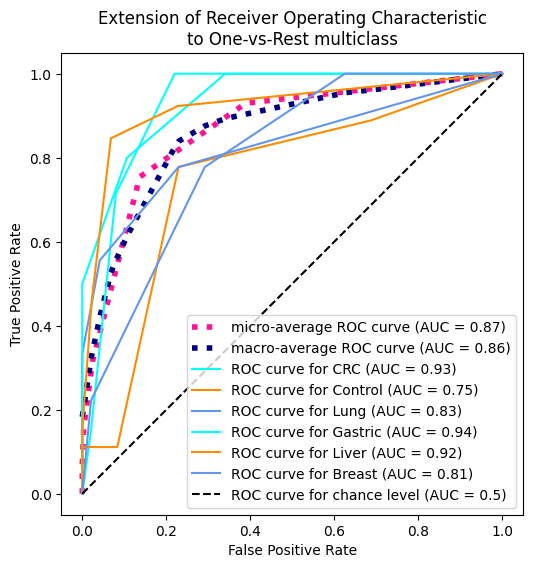

In [12]:
n_classes = 6
target_names = np.array(["CRC", "Control","Lung","Gastric","Liver","Breast"])
y_score = knn.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()